In [106]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector, Parameter
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
import math
import matplotlib.pyplot as plt

In [112]:
def create_unitary_evolution(num_address_qubits, num_embedding_qubits, evolution_indice=1):
    # Define quantum registers
    q_reg_address = QuantumRegister(num_address_qubits, name='q')
    q_reg_embedding = QuantumRegister(num_embedding_qubits, name='e')

    # Create a quantum circuit
    u1_qc = QuantumCircuit(q_reg_address, q_reg_embedding, name=str('U' + evolution_indice))

    # hadamat gate on all address qubits
    u1_qc.h(q_reg_address[:])
    # perform rotation on each address qubit with corresponding embedding qubit by theta
    for i in range(1):
        theta_params = [Parameter(f'theta_{evolution_indice}_{j}') for j in range(num_address_qubits)]
    
    for i in range(num_address_qubits - 1, -1, -1):
        u1_qc.cry(theta_params[i], i, num_address_qubits)
    # u1_qc.measure(q_reg_address[:], q_reg_embedding[:])
    
    # draw the custom circuit
    display(u1_qc.draw('mpl'))
    
    # return u1_qc.to_instruction()
    u_gate = u1_qc.to_gate()
    controlled_u_gate = u_gate.control(1)
    return controlled_u_gate

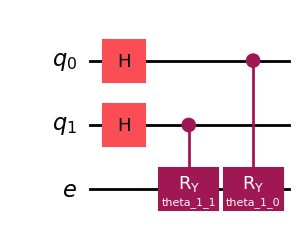

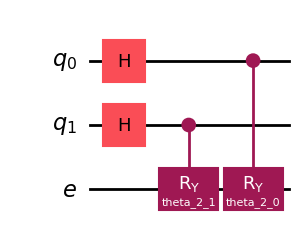

Instruction(name='U1', num_qubits=3, num_clbits=0, params=[Parameter(theta_0_0), Parameter(theta_0_1)])


In [113]:
# Example 
num_ancilla_qubits = 1
num_address_qubits = 2
num_embedding_qubits = 1
u1_gate = create_unitary_evolution(num_address_qubits, num_embedding_qubits, '1')
u2_gate = create_unitary_evolution(num_address_qubits, num_embedding_qubits, '2')
# Display the circuit
print(custom_gate)

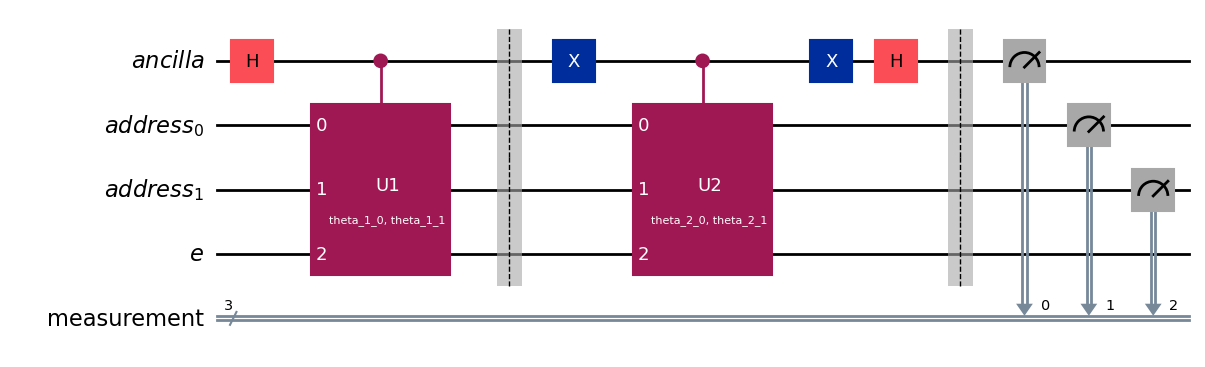

In [122]:
from qiskit.circuit.library import XGate  # Create QuantumRegisters
num_ancilla_qubits = 1
num_address_qubits = 2
num_embedding_qubits = 1
qreg_ancilla = QuantumRegister(num_ancilla_qubits, name='ancilla')
q_reg_address = QuantumRegister(num_address_qubits, name='address')
q_reg_embedding = QuantumRegister(num_embedding_qubits, name='e')

# Create ClassicalRegister for measurement if needed
cr_measurement = ClassicalRegister(num_ancilla_qubits + num_address_qubits, name='measurement')

# Create QuantumCircuit
qc = QuantumCircuit(qreg_ancilla, q_reg_address, q_reg_embedding, cr_measurement)

# Apply Hadamard gate to all ancilla qubits
qc.h(qreg_ancilla[:])

# cx gate between ancilla and all address qubits



# qc.cx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])

# Append your custom u1 and u2 instructions to the circuit
qc.append(u1_gate, qreg_ancilla[:] + q_reg_address[:] + q_reg_embedding[:])

# qc.ccx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])

# anti_gate = XGate.control(ctrl_state='0', annotated='x')
# circuit.append(anti_gate, [qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:]])
qc.barrier()
# negative control workaround ? 
# x cx x
# qc.x(qreg_ancilla[:])
# qc.cx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])
# qc.x(qreg_ancilla[:])
# qc.barrier()

qc.x(qreg_ancilla[:])
qc.append(u2_gate, qreg_ancilla[:] + q_reg_address[:] + q_reg_embedding[:])
qc.x(qreg_ancilla[:])


qc.h(qreg_ancilla[:])

qc.barrier()


qc.measure(qreg_ancilla[:], cr_measurement[0])
qc.measure(q_reg_address[:], cr_measurement[1:])

display(qc.draw('mpl'))